# Recitation 8: Cutting planes and branching

In [1]:
using JuMP, Gurobi
using Plots, LinearAlgebra, Random

# Part 1: Cuts

We consider the problem from lecture:

$$\min x_{n+1}$$ $$\text{s.t. }2\sum_{i=1}^nx_i + x_{n+1}=2k + 1.$$

Recall that because the RHS is odd, we have no choice but to set $x_{n+1}=1$. However, it can require a lot of work for the solver to figure this out. We will explore the effects of different parameters on the branch-and-bound tree.

First, we write a function to solve the problem for arbitrary $n$ and $k$:

In [2]:
"Solve the optimization problem for n and k - pass a vector of parameters to the solver..."
function odd_x(n::Int, k::Int; parameters::Vector=[])
    model = Model(Gurobi.Optimizer)
    set_optimizer_attributes(model, parameters...)
    # Define optimization problem
    @variable(model, x[1:(n+1)], Bin)
    @objective(model, Min, x[n+1])
    @constraint(model, 2 * sum(x[i] for i = 1:n) + x[n + 1] == 2 * k + 1)
    # Solve the problem
    optimize!(model)
end

odd_x

Now, let's try to solve it with default parameters, except turning off presolve.

In [3]:
odd_x(20, 10, parameters = ["Presolve" => 0])


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1 rows, 21 columns and 21 nonzeros
Model fingerprint: 0x9ecb8626
Variable types: 0 continuous, 21 integer (21 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+01]
Found heuristic solution: objective 1.0000000
Variable types: 0 continuous, 21 integer (21 binary)

Root relaxation: objective 0.000000e+00, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1    1.00000    0.00000   100%     -    0s
     0     0

We explored over 126,000 nodes and it took over 1 second to solve the problem. This is a lot of work!

Let's see if we can use solver parameters to reduce this. First, we try the `Cuts` parameter:

In [4]:
odd_x(20, 10, parameters=["Presolve" => 0,
                          "Cuts" => 1])


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1 rows, 21 columns and 21 nonzeros
Model fingerprint: 0x9ecb8626
Variable types: 0 continuous, 21 integer (21 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+01]
Found heuristic solution: objective 1.0000000
Variable types: 0 continuous, 21 integer (21 binary)

Root relaxation: objective 0.000000e+00, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1    1.00000    0.00000   100%     -    0s
     0     0

**Effect of toggling the `Cuts` parameter:**

With cuts completely off, or a "moderate" cut generating strategy, we explore over 184,000 nodes. With an aggressive cut generating strategy, we reduce the set of nodes explored to under 9000, and solve time is divided by more than 10.

It's a bit tiresome to read the logs, so let's output the number of nodes visited and the solve time directly from the function.

In [5]:
"Solve the optimization problem for n and k - pass a vector of parameters to the solver, return node count and time"
function odd_x_nodes(n::Int, k::Int; parameters::Vector=[])
    model = Model(Gurobi.Optimizer)
    set_optimizer_attributes(model, parameters...)
    # Define optimization problem
    @variable(model, x[1:(n+1)], Bin)
    @objective(model, Min, x[n+1])
    @constraint(model, 2 * sum(x[i] for i = 1:n) + x[n + 1] == 2 * k + 1)
    # Solve the problem
    solvetime = @elapsed optimize!(model)
    # Extract the number of nodes visited
    nodes = MOI.get(model, MOI.NodeCount())
    return nodes, solvetime
end

odd_x_nodes

Now, we can plot the node counts for different values of the `Cuts` parameter.

In [9]:
result = [odd_x_nodes(20, 10, parameters = ["OutputFlag" => 0, "Presolve" => 0, "Cuts" => i]) for i = [0, 1, 2]]


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27


3-element Array{Tuple{Float64,Float64},1}:
 (184761.0, 0.948839761)
 (184598.0, 0.9194598)
 (35437.0, 0.198970481)

Let's plot what that looks like

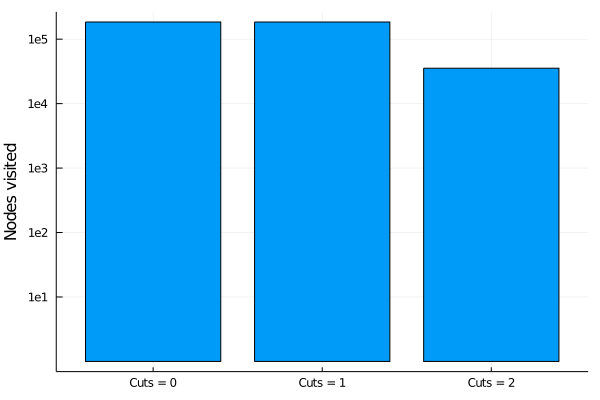

In [10]:
bar([0, 1, 2], log10.(first.(result)), yticks=([1, 2, 3, 4, 5], ["1e$i" for i = 1:5]),
    xticks = ([0, 1, 2], ["Cuts = $j" for j = 0:2]), label="", ylabel="Nodes visited")

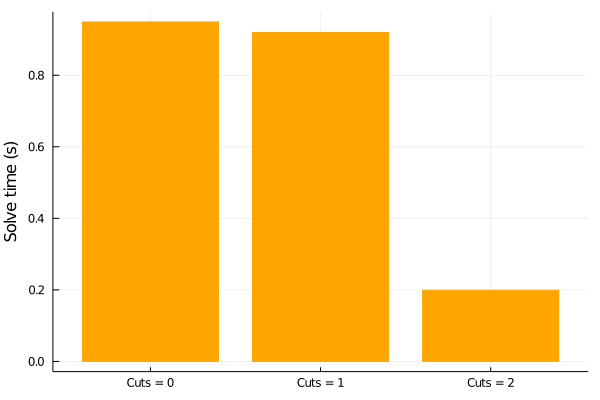

In [11]:
bar([0, 1, 2], (last.(result)), fill="orange", linecolor="orange",
    xticks = ([0, 1, 2], ["Cuts = $j" for j = 0:2]), label="", ylabel="Solve time (s)")

If we look at the logs carefully, we see that flow cover cuts (when `Cuts = 1`) and Gomory cuts (when `Cuts = 2`) are used. We can try to manipulate these manually using the parameters:
- `FlowCoverCuts`: 0 is off, 1 is moderate, 2 is aggressive
- `GomoryPasses`: indicates the number of attempts we make to add Gomory cuts (0 is off)

In [12]:
result2 = [odd_x_nodes(20, 10, parameters = ["OutputFlag" => 0, "Presolve" => 0, "Cuts" => -1,
                                            "FlowCoverCuts" => i, "GomoryPasses" => j])
           for i = [0, 1, 2], j = [0, 1, 2, 4, 8, 16, 32, 64]]


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

---------------------------------------

3×8 Array{Tuple{Float64,Float64},2}:
 (80320.0, 0.429382)  (80320.0, 0.41834)   …  (488.0, 0.0176826)
 (43588.0, 0.239428)  (43588.0, 0.235451)     (488.0, 0.0172474)
 (43588.0, 0.271273)  (43588.0, 0.259517)     (274.0, 0.016119)

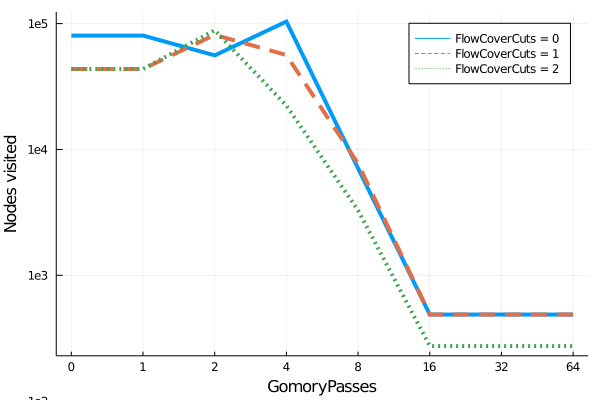

In [13]:
plot(log10.(first.(result2))', label=permutedims(["FlowCoverCuts = $i" for i = 0:2]), lw=4, ls=:auto,
     xticks = (collect(1:8), [0, 1, 2, 4, 8, 16, 32, 64]), xlabel="GomoryPasses",
     yticks=([1, 2, 3, 4, 5], ["1e$i" for i = 1:5]), ylabel="Nodes visited")

If we are aggressive enough about generating Gomory cuts, we can really simplify the problem a lot.

It turns out that the top-level `Cuts` parameter can take values beyond 0 (off), 1 (moderate) and 2 (aggressive). We can set `Cuts=3` for very aggressive cut generation.

In [14]:
odd_x(100, 50, parameters=["OutputFlag" => 1, "Presolve" => 0, "Cuts" => 2])


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1 rows, 101 columns and 101 nonzeros
Model fingerprint: 0xceab37e2
Variable types: 0 continuous, 101 integer (101 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 1e+02]
Found heuristic solution: objective 1.0000000
Variable types: 0 continuous, 101 integer (101 binary)

Root relaxation: objective 0.000000e+00, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1    1.00000    0.00000   100%     -    0s
     0

**Result:** We got it down to exploring a single node! When tinkering with parameters, it's always a good idea to check the highest-level parameters first...

# Part 2: Symmetry

The problem we've considered so far is highly symmetric! In fact, we really do not care which $k$ variables among the first $n$ we set to 1. Gurobi has a way to detect and correct for symmetric formulations.

In [15]:
odd_x(20, 10, parameters=["OutputFlag" => 1, "Presolve" => 0, "Cuts"=> 2, "Symmetry" => 2])


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1 rows, 21 columns and 21 nonzeros
Model fingerprint: 0x9ecb8626
Variable types: 0 continuous, 21 integer (21 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+01]
Found heuristic solution: objective 1.0000000
Variable types: 0 continuous, 21 integer (21 binary)

Root relaxation: objective 0.000000e+00, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1    1.00000    0.00000   100%     -    0s
     0     0

Unfortunately, it looks like Gurobi is not able to find any symmetry in the formulation, and the number of explored nodes is not reduced...

However, we know there are ways to reduce symmetry. In particular, we can impose an **order** on the first $n$ variables, by ensuring that $x_i=1$ only if $x_{i-1}=1$. We can modify the formulation as:

In [16]:
"Solve the optimization problem for n and k - pass a vector of parameters to the solver"
function odd_x_fast(n::Int, k::Int; parameters::Vector=[])
    model = Model(Gurobi.Optimizer)
    set_optimizer_attributes(model, parameters...)
    # Define optimization problem
    @variable(model, x[1:(n+1)], Bin)
    @objective(model, Min, x[n+1])
    @constraint(model, 2 * sum(x[i] for i = 1:n) + x[n + 1] == 2 * k + 1)
    @constraint(model, [i = 1:(n-1)], x[i] >= x[i+1])
    # Solve the problem
    optimize!(model)
end

odd_x_fast

And when we apply it to the problem...

In [17]:
odd_x_fast(20, 10, parameters = ["OutputFlag" => 1, "Presolve" => 0])


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 20 rows, 21 columns and 59 nonzeros
Model fingerprint: 0x08486fd1
Variable types: 0 continuous, 21 integer (21 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+01]
Found heuristic solution: objective 1.0000000
Variable types: 0 continuous, 21 integer (21 binary)

Root relaxation: objective 0.000000e+00, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0         1.00000    1.00000  0.00%     -    0s

Explored 

... we find that the solver immediately deduces that $x_{n+1}=0$ is infeasible.

# Part 3: Branching

Another way to solve problems more efficiently is to modify the branching scheme. We can control this at a high-level using the `VarBranch` parameter, which can take the following values:
- Choose automatically (-1)
- Pseudo reduced cost branching (0)
- Pseudo shadow price branching (1)
- Maximum infeasibility branching (2)
- Strong branching (3)

To test the impact of this parameter, we will use a problem instance from [MIPLIB](https://miplib.zib.de/index.html), a library of MIP instances that is used for benchmarking new algorithms. 

In [18]:
function solve_markshare(parameters = [])
    new_model = read_from_file("markshare4.mps")
    set_optimizer(new_model, Gurobi.Optimizer)
    set_optimizer_attributes(new_model, parameters...)
    solvetime = @elapsed optimize!(new_model)
    return (solvetime, MOI.get(new_model, MOI.NodeCount()))
end

solve_markshare (generic function with 2 methods)

Let's solve it for varying branching strategies, and plot the result.

In [26]:
result3 = [solve_markshare(["Presolve" => 1, "Cuts" => 0, "VarBranch" => i, "OutputFlag" => 0,
                           "Heuristics" => 0, "TimeLimit" => 30]) for i = -1:3];


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27


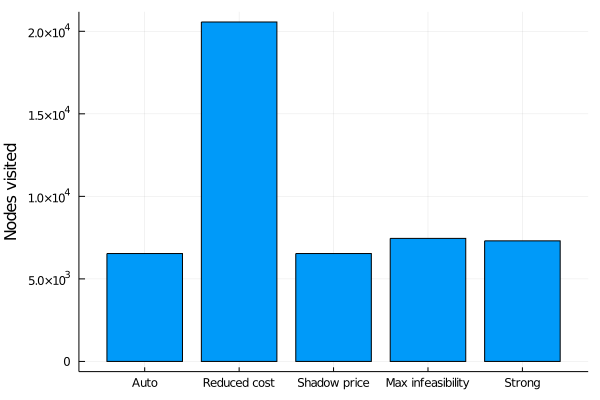

In [27]:
bar(collect(-1:3), (last.(result3)),
    xticks = ([-1, 0, 1, 2, 3], ["Auto", "Reduced cost", "Shadow price", "Max infeasibility", "Strong"]),
    label="", ylabel="Nodes visited")

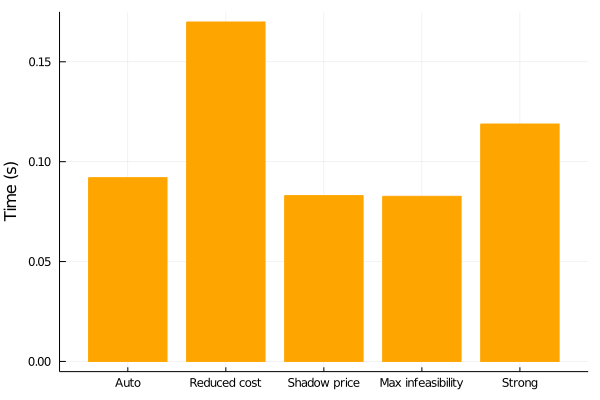

In [28]:
bar(collect(-1:3), (first.(result3)), fill="orange", lc="orange",
    xticks = ([-1, 0, 1, 2, 3], ["Auto", "Reduced cost", "Shadow price", "Max infeasibility", "Strong"]),
    label="", ylabel="Time (s)")

There is not a clear winner here: strong branching reduces the number of nodes significantly, but also takes more time making each branching decision.

Can we use the branching strategies to reduce the number of nodes in our first example?

In [29]:
result4 = [odd_x_nodes(20, 10, parameters = ["OutputFlag" => 0, "Presolve" => 0,
                                             "Cuts" => 0, "VarBranch" => i]) for i = -1:3]
@show first.(result4);


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27
first.(result4) = [184761.0, 184761.0, 184761.0, 184761.0, 184761.0]


The effect of the high-level branching strategy is not significant. We know much more about the structure of the problem than what we've told Gurobi, so it is still having trouble.

Next, we can try a more fine-grained method to modify branching decisions. Consider the following example with two binary variables, and let the objective be to maximize $y$. The optimal fractional solution is $(\frac{1}{2}, \frac{5}{6})$.

![](example.pdf)

If we branch on $x$ first, we obtain the following disjunction:

![](example-branch1.pdf)

In this case, the optimal solution to the relaxation is $(0, \frac{1}{3})$, and we need to branch again to get an integral solution. In contrast, if we had branched on $y$ first, we would have immediately obtained the convex hull of the integer set:

![](example-branch2.pdf)

In our case, it's not totally clear which variable we should prioritize, but let's try it out! For any variable, we can set the `BranchPriority` attribute to tell Gurobi how to branch. However, we should keep in mind that Gurobi already has an ordering strategy in mind (which is proprietary), so we do not know if it will actually follow our recommendation!

In [30]:
"Same as before, try to toggle branching priority"
function odd_x_priority(n::Int, k::Int; parameters::Vector=[])
    # To access low-level solver attributes, we need to use direct_model
    # The main difference is that JuMP does not "cache" any of the variables or constraints,
    # so we have less memory overhead, but we can't change the solver later on
    model = direct_model(Gurobi.Optimizer())
    set_optimizer_attributes(model, parameters...)
    @variable(model, x[1:(n+1)], Bin)
    @objective(model, Min, x[n+1])
    @constraint(model, 2 * sum(x[i] for i = 1:n) + x[n + 1] == 2 * k + 1)
    # We can set the BranchPriority attribute as follows - default value is 0, higher means higher priority
    MOI.set(model, Gurobi.VariableAttribute("BranchPriority"), x[n + 1], 2)
    solvetime = @elapsed optimize!(model)
    return MOI.get(model, MOI.NodeCount()), solvetime
end

odd_x_priority

In [31]:
result5 = [odd_x_priority(20, 10, parameters = ["OutputFlag" => 0, "Presolve" => 0,
                                                "Cuts" => 0, "VarBranch" => i]) for i = -1:3]
@show first.(result5);


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27
first.(result5) = [184761.0, 184761.0, 184761.0, 184761.0, 184761.0]


And the verdict is in... absolutely nothing changed. We need to do something deeper than changing the branching priority.

# Part 4: Custom branching

## 4.1 A better formulation

The problem we are trying to solve has a lot of symmetry. It might be a good idea to modify the formulation slightly to allow for better branching!

For example, we could define new binary variables $t_1, t_2, \ldots, t_n$ such that $t_j=0$ turns off the last $n-j+1$ variables $x_i$, i.e.,

$$\sum_{i=j}^n x_i \le (n-j+1) t_j$$

In [32]:
"Solve the optimization problem for n and k - pass a vector of parameters to the solver"
function odd_x_branch(n::Int, k::Int; parameters::Vector=[])
    model = Model(Gurobi.Optimizer)
    set_optimizer_attributes(model, parameters...)
    # Define optimization problem
    @variable(model, x[1:(n+1)], Bin)
    @objective(model, Min, x[n+1])
    @constraint(model, 2 * sum(x[i] for i = 1:n) + x[n + 1] == 2 * k + 1)
    
    #make t continuous
    @variable(model, t[1:n], Bin)
    @constraint(model, [j=1:n], sum(x[i] for i = j:n) <= (n - j + 1) * t[j])
    # Solve the problem
    solvetime = @elapsed optimize!(model)
    return MOI.get(model, MOI.NodeCount()), solvetime
end

odd_x_branch

In [33]:
result6 = [odd_x_branch(20, 10, parameters = ["OutputFlag" => 0, "Presolve" => 0, "Cuts" => i]) for i = 0:2]


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27


3-element Array{Tuple{Float64,Float64},1}:
 (184761.0, 2.029280367)
 (5.0, 0.016382508)
 (5.0, 0.023530625)

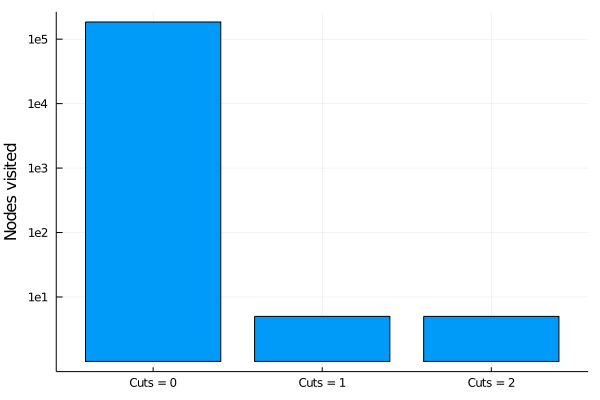

In [34]:
bar([0, 1, 2], log10.(first.(result6)), yticks=([1, 2, 3, 4, 5], ["1e$i" for i = 1:5]),
    xticks = ([0, 1, 2], ["Cuts = $j" for j = 0:2]), label="", ylabel="Nodes visited")

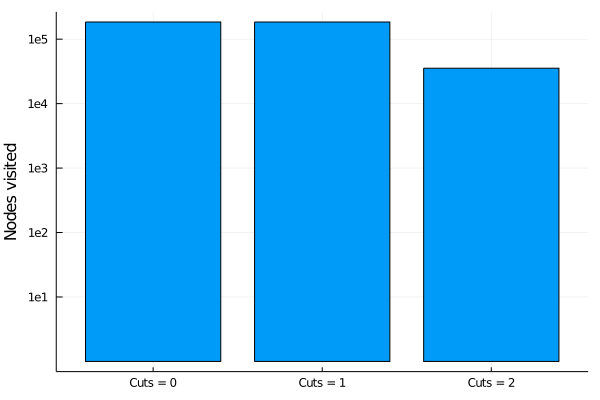

In [35]:
bar([0, 1, 2], log10.(first.(result)), yticks=([1, 2, 3, 4, 5], ["1e$i" for i = 1:5]),
    xticks = ([0, 1, 2], ["Cuts = $j" for j = 0:2]), label="", ylabel="Nodes visited")

Here, we find that augmenting the formulation makes it a lot easier to branch - and there is also strong interaction with the `Cuts` parameter. Often the two work together. If you find a formulation improvement that makes it easier to branch, chances are you will also be able to generate good cuts.

## 4.2 Orbital branching

At the end of lecture, we mentioned that this problem is not well-suited to a simple branching scheme. Instead, we introduced the notion of *orbital branching*.

How does this work? Consider the following disjunction:

$$x_1=1 \cup x_2=1 \cup \ldots \cup x_n = 1 \cup \sum_{i=1}^n x_i = 0$$

There are $n+1$ options above. But due to symmetry, the first $n$ of them will lead to identical nodes in the branch-and-bound tree. So we can simply throw $n-1$ of them out, leaving us with the following branching:

$$x_1=1 \cup \sum_{i=1}^n x_i = 0.$$

Now, we can take a look at the first branch. We've set $x_1=1$, but we have made no assumptions about the other variables. But we can repeat the process, and simplify the disjunction

$$x_2=1 \cup \ldots \cup x_n = 1 \cup \sum_{i=2}^n x_i = 0$$

to 

$$x_2=1 \cup \sum_{i=2}^n x_i = 0.$$

Ideally, we'd specify to Gurobi how to perform this kind of branching, but unfortunately Gurobi doesn't give us that kind of access. If we want that kind of access, we need to use a more malleable solver like SCIP... or we can just implement the branch-and-bound scheme ourselves.

**How do we do this?**

In this simple problem, what we are trying to do is show that $x_{n+1}=0$ is infeasible, and therefore the minimum value of the objective is $x_{n+1}=1$. We can iterate through the disjunctions listed above and show that all of them are infeasible for $x_{n+1}=0$.

We can use the functions `JuMP.fix` and `JuMP.unfix` to set and unset specific assignments to each variable.

In [36]:
"Solve the problem using orbital branching, returns optimal value of x[n+1]"
function odd_x_orbital(n::Int, k::Int; parameters::Vector=[])
    model = Model(Gurobi.Optimizer)
    set_optimizer_attributes(model, parameters...)
    # Define optimization problem
    @variable(model, x[1:n], Bin)
    @constraint(model, 2 * sum(x[i] for i = 1:n) == 2 * k + 1)
    # first we set all the variables to 0 - first orbital disjunction
    for i = 1:n
        JuMP.fix(x[i], 0)
    end
    optimize!(model)
    if termination_status(model) != MOI.INFEASIBLE
        return 0
    end
    # now we go through the left branch of the tree, and check each orbital disjunction
    for j = 1:n
        JuMP.fix(x[j], 1)
        optimize!(model)
        if termination_status(model) != MOI.INFEASIBLE
            return 0
        end
    end
    return 1
end

odd_x_orbital

In [37]:
@time odd_x_orbital(20, 10, parameters=["Presolve" => 0, "TimeLimit" => 10, "OutputFlag" => 0, "Cuts" => 0])


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-04-27
  0.739837 seconds (1.66 M allocations: 83.702 MiB, 3.85% gc time)


1

Note that in this example, we don't even use Gurobi's IP capabilities, and we just ending up solving a series of LPs, all of which are infeasible. We end up exploring just 21 nodes.